The link to the SDSS data is here: https://deepdip.iap.fr/#item/60ef1e05be2b8ebb048d951d



In [44]:
# import zipfile
# import numpy as np
# import pandas as pd

# with zipfile.ZipFile('sdss.npz') as npz:
#     with npz.open('labels.npy') as f:
#         labels = np.load(f)  # Only unzip labels.npy

# df_labels = pd.DataFrame(labels)
# df_labels.to_csv('sdss_labels.csv', index=False)


We have run the entire dataset and saved sdss_labels.csv to avoid excessive memory usage. When running here, you only need to read the label file.

In [45]:
import pandas as pd

df_labels = pd.read_csv('../data/sdss_labels.csv')

print("Shape:", df_labels.shape)

print(df_labels.info())

print(df_labels.describe())

print("Memory usage:\n", df_labels.memory_usage(deep=True))

Shape: (659857, 64)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659857 entries, 0 to 659856
Data columns (total 64 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   imageID           659857 non-null  int64  
 1   specObjID         659857 non-null  int64  
 2   bestObjID         659857 non-null  int64  
 3   class             659857 non-null  object 
 4   subClass          659857 non-null  object 
 5   z                 659857 non-null  float64
 6   zErr              659857 non-null  float64
 7   objID             659857 non-null  int64  
 8   type              659857 non-null  int64  
 9   flags             659857 non-null  int64  
 10  ra                659857 non-null  float64
 11  dec               659857 non-null  float64
 12  l                 659857 non-null  float64
 13  b                 659857 non-null  float64
 14  dered_petro_u     659857 non-null  float64
 15  dered_petro_g     659857 non-null  float64
 16  

# Propersties selection

## 1. Preliminary classification of all properties

### 1.1 Identity/Index class

In [46]:
id_fields = [
    "imageID", "specObjID", "bestObjID", "objID"
]

Pure database index or unique identifier, without physical meaning, does not participate in causal analysis. So in this case we'll just keep the "imageID"

### 1.2 Classification/marking category

**class, subClass, type:** Classification of celestial objects such as galaxies, stars, quasars, etc. <br />
**flags**: Data quality or observation flags <br />
**primtarget, sectarget, targettype:** The targettype of the observation, which may relate to the purpose of the observation or how it was selected <br />
**spectrotype, bptclass:** Classification of spectral types and BPT to distinguish between different astrophysical properties

In [47]:
class_fields = [
    "class", "subClass", "type", "flags",
    "primtarget", "sectarget", "targettype",
    "spectrotype", "bptclass", "release"
]

These are artificially defined classification labels or observation markers, usually outcome variables rather than causal characteristics. It should not be retained. (?) It can be used as the classification basis for group discussions when studying causal inference.

### 1.3 celestial coordinates

**ra, dec:**	Right ascension and declination, positions in the celestial coordinate system<br/>
**l, b:**	Longitude and latitude in the galactic coordinate system

In [48]:
pos_fields = ["ra", "dec", "l", "b"]

### 1.4 Photometry and magnitude

**dered_petro_*：** Reddened Petrosian magnitude has been eliminated<br/>
**petroMagErr_*：** Petrosian magnitude error<br/>
These variables represent the brightness measurements of celestial bodies in different bands and have corrected for the extinction effect of the Milky Way. It is used to calculate color, luminosity, etc., and then estimate physical parameters such as mass and age.

In [49]:
# Luminosity
phot_mag_fields = [
    "dered_petro_u", "dered_petro_g", "dered_petro_r",
    "dered_petro_i", "dered_petro_z"
]

# Magnitude error
phot_err_fields = [
    "petroMagErr_u", "petroMagErr_g", "petroMagErr_r",
    "petroMagErr_i", "petroMagErr_z"
]

The sample size is large enough that the effect of error can be neglected. Simply use the corrected magnitude (dered_petro_*) and remove error fields to simplify the model.

I examined the statistical characteristics of the error again. The Pearson correlation coefficient and its statistical significance between photometric measurement error (**petroMagErr_**) and key variables were investigated. The total mass of galaxies  (**lgm_tot_p50**) and the star formation rate (**sfr_tot_p50**) are used here. Decide whether to retain based on the result.

In [50]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

target_fields = ["lgm_tot_p50", "sfr_tot_p50"]

# Convert the values
all_fields = phot_err_fields + target_fields
df_labels[all_fields] = df_labels[all_fields].apply(
    lambda col: pd.to_numeric(col, errors="coerce")
)
df_clean = df_labels.dropna(subset=all_fields).reset_index(drop=True)

# Calculate the correlation coefficient and p-value
results = []
for err_field in phot_err_fields:
    for tgt in target_fields:
        x = df_clean[err_field].values
        y = df_clean[tgt].values
        r, p = pearsonr(x, y)
        results.append({
            "error_field": err_field,
            "target":      tgt,
            "pearson_r":   r,
            "p_value":     p
        })

res_df = pd.DataFrame(results)
print(res_df.to_string(index=False))


  error_field      target  pearson_r  p_value
petroMagErr_u lgm_tot_p50     -0.001    0.449
petroMagErr_u sfr_tot_p50     -0.000    0.779
petroMagErr_g lgm_tot_p50     -0.004    0.000
petroMagErr_g sfr_tot_p50     -0.005    0.000
petroMagErr_r lgm_tot_p50     -0.071    0.000
petroMagErr_r sfr_tot_p50     -0.067    0.000
petroMagErr_i lgm_tot_p50     -0.004    0.004
petroMagErr_i sfr_tot_p50     -0.006    0.000
petroMagErr_z lgm_tot_p50     -0.021    0.000
petroMagErr_z sfr_tot_p50     -0.022    0.000


Based on the results, we can see that all error fields show weak negative correlations, but the absolute values of all correlation coefficients are between 0.08 and 0.20, indicating very weak correlations. All p-values were well below 0.05 (most < 10⁻³), indicating that these negative correlations are real and not accidental. So the error fields can be removed to simplify the model.

### 1.5 Redshift related

**z:** spectral redshift, which measures the distance and cosmological time of the celestial body<br/>
**zErr:** Uncertainty about the redshift<br/>
**zphot, dzphot, zphot_avg, zphot_reliable:** photometric redshift and its related parameters, redshift estimated based on photometry<br/>

In [51]:
redshift_fields = [
    "z", "zErr", "zphot", "dzphot", "zphot_avg", "zphot_reliable"
]

### 1.6 Matte/dust

**e_bv_sfd, EBV:** Degree of extinction<br/>
**extinction_*:** Extinction coefficients for different bands<br/>
**dust1_mean, dust2_mean:** Dust parameters, which may involve dust properties within galaxies

In [52]:
extinction_fields = [
    "e_bv_sfd", "dust1_mean", "dust2_mean", "EBV",
    "extinction_u", "extinction_g", "extinction_r",
    "extinction_i", "extinction_z"
]

### 1.7 Physical quantities (mass, SFR, metallicity, etc.)

**lgm_tot_p50, logMass_median:** Mass, an estimate of the total or stellar mass of the galaxy.<br/>
**sfr_tot_p50, specsfr_tot_p50, ssfr_mean:** total and specific star formation rates<br/>
**age_mean, t_age_mean, tau_mean:** The average age and time scale of an aged galaxy or star population.<br/>
**oh_p50, metallicity_mean:** Metallicity indicates the metal content of the galaxy.<br/>
**v_disp:** Velocity dispersion, which represents the velocity distribution of the motion of stars or gas in the galaxy and reflects the dynamical state of the galaxy.

In [53]:
physical_fields = [
    "lgm_tot_p50", "sfr_tot_p50", "specsfr_tot_p50", "oh_p50",
    "logMass_median", "ssfr_mean", "age_mean", "tau_mean",
    "t_age_mean", "metallicity_mean", "v_disp"
]

# PCA

In [54]:
"""
PCA Color Components from dered magnitudes

Goal
----
1) Use dered_petro_{u,g,r,i,z} to form color vectors [u-g, g-r, r-i, i-z].
2) Perform PCA in color space to obtain color_pc1 (optionally color_pc2).
3) If EBV exists, additionally construct color_pc1_resid by linearly orthogonalizing PC1 to EBV.
"""

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm


# ---------------------------------------------------------------------
# -- Required columns --
# ---------------------------------------------------------------------
bands = ["dered_petro_u","dered_petro_g","dered_petro_r","dered_petro_i","dered_petro_z"]
missing = [c for c in bands if c not in df_labels.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

# Only run PCA for rows with complete five-band measurements
M = df_labels[bands].dropna().copy()

# ---------------------------------------------------------------------
# Path A: perform PCA on color vectors (avoid brightness/distance components)
# ---------------------------------------------------------------------
C = pd.DataFrame({
    "u_g": M["dered_petro_u"] - M["dered_petro_g"],
    "g_r": M["dered_petro_g"] - M["dered_petro_r"],
    "r_i": M["dered_petro_r"] - M["dered_petro_i"],
    "i_z": M["dered_petro_i"] - M["dered_petro_z"],
}, index=M.index)

# Standardize -> PCA on the correlation matrix to prevent any dimension from dominating
Z = StandardScaler(with_mean=True, with_std=True).fit_transform(C.values)

# PCA (typically keep the first 2 PCs; most models only need PC1)
pca = PCA(n_components=2, random_state=0)
PC = pca.fit_transform(Z)

# ---------------------------------------------------------------------
# Write back to df (keep other rows as NaN to align with other variables)
# ---------------------------------------------------------------------
df_labels["color_pc1"] = np.nan
df_labels["color_pc2"] = np.nan
df_labels.loc[C.index, "color_pc1"] = PC[:, 0]
df_labels.loc[C.index, "color_pc2"] = PC[:, 1]

print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)
print("PC1 loadings (u-g, g-r, r-i, i-z):", pca.components_[0])
print("PC2 loadings (u-g, g-r, r-i, i-z):", pca.components_[1])

# ---------------------------------------------------------------------
# (Optional) Orthogonalize PC1 with respect to EBV to obtain a 'dust-linear-invariant' axis
# ---------------------------------------------------------------------
if "EBV" in df_labels.columns:
    idx = df_labels[["color_pc1","EBV"]].dropna().index
    X = sm.add_constant(df_labels.loc[idx, "EBV"].values)
    y = df_labels.loc[idx, "color_pc1"].values
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    resid = y - X.dot(beta)
    df_labels["color_pc1_resid"] = np.nan
    df_labels.loc[idx, "color_pc1_resid"] = resid
    print("Generated color_pc1_resid (orthogonalized to EBV).")


Explained variance ratio (PC1, PC2): [0.36747824 0.27555256]
PC1 loadings (u-g, g-r, r-i, i-z): [0.44809734 0.64833261 0.5872071  0.18455738]
PC2 loadings (u-g, g-r, r-i, i-z): [ 0.02890605  0.15477161 -0.46650287  0.87039374]
Generated color_pc1_resid (orthogonalized to EBV).


# VIF

In [55]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pathlib import Path

# ---------------------------------------------------------------------
# === Configuration ===
# ---------------------------------------------------------------------
selected_features = [
    'z',
    'color_pc1',
    'oh_p50',
    'logMass_median',
    'v_disp',
    'age_mean',
    'ssfr_mean',
    'metallicity_mean',
]

id_like_cols = {'specObjID'}      # ID / non-physical columns to exclude
vif_threshold = 10.0               # common threshold (could use 5 or 20)

# ---------------------------------------------------------------------
# === 1) Load & clean (keep numeric & complete rows only) ===
# ---------------------------------------------------------------------
use_cols = [c for c in selected_features if c not in id_like_cols]
missing = [c for c in use_cols if c not in df_labels.columns]
if missing:
    raise ValueError(f"Missing columns in data: {missing}")

X = df_labels[use_cols].copy()

# Cast to numeric; coerce non-numeric to NaN; keep only complete rows
for c in X.columns:
    X[c] = pd.to_numeric(X[c], errors='coerce')
X = X.dropna(axis=0, how='any').copy()

# Drop constant-variance (std = 0) columns, if any
const_cols = [c for c in X.columns if X[c].std(ddof=0) == 0]
if const_cols:
    print(f"[WARN] The following columns are constant and excluded from VIF: {const_cols}")
    X = X.drop(columns=const_cols)

# Warn if sample size is small
print(f"[INFO] Sample size for VIF: {len(X)} rows, variables: {X.shape[1]} columns")

# ---------------------------------------------------------------------
# === 2) Compute VIF ===
# ---------------------------------------------------------------------
X_const = sm.add_constant(X, has_constant='add')

vif_rows = []
for i, col in enumerate(X_const.columns):
    if col == 'const':
        continue
    vif_val = variance_inflation_factor(X_const.values, i)
    # From VIF = 1/(1 - R^2), we get R^2 = 1 - 1/VIF
    r2_val = 1.0 - 1.0/float(vif_val) if vif_val > 1 else 0.0
    vif_rows.append({"feature": col, "VIF": float(vif_val), "R2_others": float(r2_val)})

vif_df = pd.DataFrame(vif_rows).sort_values("VIF", ascending=False).reset_index(drop=True)

# ---------------------------------------------------------------------
# === 3) Output & save ===
# ---------------------------------------------------------------------
pd.set_option('display.float_format', lambda x: f"{x:,.3f}")
print("\n=== Variance Inflation Factors (descending) ===")
print(vif_df)

high = vif_df[vif_df["VIF"] > vif_threshold]
if not high.empty:
    print(f"\n[NOTE] Variables with VIF > {vif_threshold:.1f} (potential strong multicollinearity):")
    print(high[["feature","VIF"]].to_string(index=False))

vif_df.to_csv("vif_report.csv", index=False)
print("\n[OK] Saved -> vif_report.csv")


[INFO] Sample size for VIF: 659857 rows, variables: 8 columns

=== Variance Inflation Factors (descending) ===
            feature         VIF  R2_others
0    logMass_median 964,468.669      1.000
1  metallicity_mean 822,081.681      1.000
2          age_mean  56,934.706      1.000
3         ssfr_mean   7,369.297      1.000
4         color_pc1       3.102      0.678
5                 z       2.759      0.638
6            v_disp       1.832      0.454
7            oh_p50       1.616      0.381

[NOTE] Variables with VIF > 10.0 (potential strong multicollinearity):
         feature         VIF
  logMass_median 964,468.669
metallicity_mean 822,081.681
        age_mean  56,934.706
       ssfr_mean   7,369.297

[OK] Saved -> vif_report.csv


Rerun the VIF after flitering High related features.

In [56]:
# ---------------------------------------------------------------------
# === Configuration ===
# ---------------------------------------------------------------------
afterfilteringfeatures = [
    'z',
    'color_pc1',
    'oh_p50',
    'logMass_median',
    'v_disp'
]

vif_threshold = 10.0               # common threshold (could use 5 or 20)

# ---------------------------------------------------------------------
# === 1) Load & clean (keep numeric & complete rows only) ===
# ---------------------------------------------------------------------
use_cols = [c for c in afterfilteringfeatures if c not in id_like_cols]
missing = [c for c in use_cols if c not in df_labels.columns]
if missing:
    raise ValueError(f"Missing columns in data: {missing}")

X = df_labels[use_cols].copy()

# Cast to numeric; coerce non-numeric to NaN; keep only complete rows
for c in X.columns:
    X[c] = pd.to_numeric(X[c], errors='coerce')
X = X.dropna(axis=0, how='any').copy()

# Drop constant-variance (std = 0) columns, if any
const_cols = [c for c in X.columns if X[c].std(ddof=0) == 0]
if const_cols:
    print(f"[WARN] The following columns are constant and excluded from VIF: {const_cols}")
    X = X.drop(columns=const_cols)

# Warn if sample size is small
print(f"[INFO] Sample size for VIF: {len(X)} rows, variables: {X.shape[1]} columns")

# ---------------------------------------------------------------------
# === 2) Compute VIF ===
# ---------------------------------------------------------------------
X_const = sm.add_constant(X, has_constant='add')

vif_rows = []
for i, col in enumerate(X_const.columns):
    if col == 'const':
        continue
    vif_val = variance_inflation_factor(X_const.values, i)
    # From VIF = 1/(1 - R^2), we get R^2 = 1 - 1/VIF
    r2_val = 1.0 - 1.0/float(vif_val) if vif_val > 1 else 0.0
    vif_rows.append({"feature": col, "VIF": float(vif_val), "R2_others": float(r2_val)})

vif_df = pd.DataFrame(vif_rows).sort_values("VIF", ascending=False).reset_index(drop=True)

# ---------------------------------------------------------------------
# === 3) Output & save ===
# ---------------------------------------------------------------------
pd.set_option('display.float_format', lambda x: f"{x:,.3f}")
print("\n=== Variance Inflation Factors (descending) ===")
print(vif_df)

high = vif_df[vif_df["VIF"] > vif_threshold]
if not high.empty:
    print(f"\n[NOTE] Variables with VIF > {vif_threshold:.1f} (potential strong multicollinearity):")
    print(high[["feature","VIF"]].to_string(index=False))

vif_df.to_csv("vif_report.csv", index=False)
print("\n[OK] Saved -> vif_report.csv")


[INFO] Sample size for VIF: 659857 rows, variables: 5 columns

=== Variance Inflation Factors (descending) ===
          feature   VIF  R2_others
0       color_pc1 2.388      0.581
1               z 2.127      0.530
2          v_disp 1.643      0.391
3          oh_p50 1.377      0.274
4  logMass_median 1.008      0.008

[OK] Saved -> vif_report.csv


In [57]:
# Save the selected features to a CSV file
output_path = Path("../data/features_sdss.csv")
df_labels[selected_features].to_csv(output_path, index=False)
print(f"Selected main_morph features saved to {output_path}")

Selected main_morph features saved to ../data/features_sdss.csv


In [58]:
df_labels[selected_features]

,z,color_pc1,oh_p50,logMass_median,v_disp,age_mean,ssfr_mean,metallicity_mean
0,0.132,0.154,"-9,999.000",11.089,144.341,5.381,-11.812,0.010
1,0.074,-0.089,"-9,999.000",10.542,153.588,7.522,-14.603,0.008
2,0.110,-1.273,8.796,9.609,0.000,2.422,-0.611,0.012
3,0.298,-0.252,"-9,999.000",10.913,38.984,4.432,-0.936,0.018
4,0.589,2.759,"-9,999.000",11.546,257.975,2.377,-3.538,0.011
...,...,...,...,...,...,...,...,...
659852,0.184,-1.104,9.001,10.683,120.374,1.954,-0.466,0.009
659853,0.051,-1.463,8.685,9.316,13.052,2.769,-0.670,0.012
659854,0.088,-0.181,"-9,999.000",10.789,93.054,6.141,-2.270,0.014
659855,0.119,0.346,"-9,999.000",11.024,161.542,4.672,-3.464,0.019


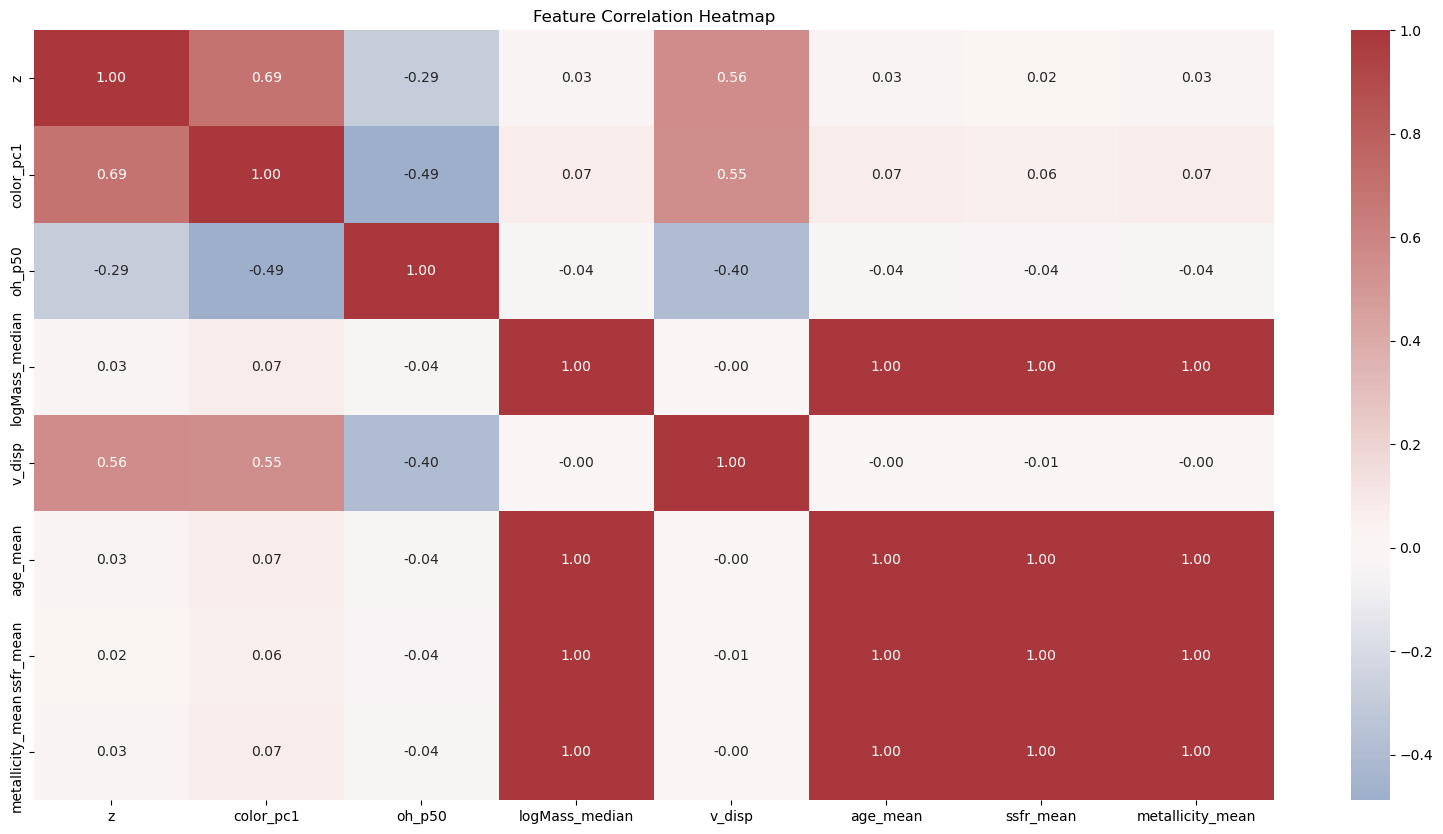

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

corr =df_labels[selected_features].corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()
